# Affiliation extraction

Adapted from code by Diego Charrez

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import json
from collections import defaultdict
from string_sim import cos_sim_pair

## Text scrape

In [3]:
data_folder = "data/neurips_2019/meta/"
out_folder = "out/neurips_2019/"
data_fname = data_folder + "raw_data_090819.txt"

In [4]:
!head -3 "data/neurips_2019/meta/raw_data_090819.txt"

<p><b>Multimodal Model-Agnostic Meta-Learning via Task-Aware Modulation</b><br><i>Risto Vuorio (University of Michigan) &middot; Shao-Hua Sun (University of Southern California) &middot; Hexiang Hu (University of Southern California) &middot; Joseph Lim (University of Southern California)</i></p>
      <p><b>ViLBERT: Pretraining Task-Agnostic Visiolinguistic Representations for Vision-and-Language Tasks</b><br><i>Jiasen Lu (Georgia Tech) &middot; Dhruv Batra (Georgia Tech / Facebook AI Research (FAIR)) &middot; Devi Parikh (Georgia Tech / Facebook AI Research (FAIR)) &middot; Stefan Lee (Georgia Institute of Technology)</i></p>
      <p><b>Stochastic Shared Embeddings: Data-driven Regularization of Embedding Layers</b><br><i>Liwei Wu (University of California, Davis) &middot; Shuqing Li (University of California, Davis) &middot; Cho-Jui Hsieh (UCLA) &middot; James Sharpnack (UC Davis)</i></p>


In [5]:
raw_affiliations = list()
titles = list()
pattern = '(\([A-z\.,/ ]+\(.*?\)[A-z\.,/ ]+\)|\(.*?\(?\)?\))' # '\(.*?\)'  # '(\([A-z\.,/ ]+\(.*?\)[A-z\.,/ ]+\)|\(.*?\(?\)?\))'
with open(data_fname, 'r') as file:
    for paper in file:
        soup = BeautifulSoup(paper, features="html.parser")
        # print(soup.i.get_text())
        raw_affiliations.append(''.join(re.findall(pattern, soup.i.get_text())))
        titles.append(soup.b.get_text())

In [6]:
len(raw_affiliations), len(''.join(raw_affiliations)), raw_affiliations[:5]

(1429,
 123713,
 ['(University of Michigan)(University of Southern California)(University of Southern California)(University of Southern California)',
  '(Georgia Tech)(Georgia Tech / Facebook AI Research (FAIR))(Georgia Tech / Facebook AI Research (FAIR))(Georgia Institute of Technology)',
  '(University of California, Davis)(University of California, Davis)(UCLA)(UC Davis)',
  '(The University of Adelaide)(Tusimple)(Hong Kong University of Science and Technology)(The University of Adelaide)(University of Adelaide)(Nankai University)(University of Adelaide)',
  '(Seoul National University)(Seoul National University)'])

In [7]:
titles[:5]

['Multimodal Model-Agnostic Meta-Learning via Task-Aware Modulation',
 'ViLBERT: Pretraining Task-Agnostic Visiolinguistic Representations for Vision-and-Language Tasks',
 'Stochastic Shared Embeddings: Data-driven Regularization of Embedding Layers',
 'Unsupervised Scale-consistent Depth and Ego-motion Learning from Monocular Video',
 'Zero-shot Learning via Simultaneous Generating and Learning']

## All affiliations

In [8]:
def load_json(fname):
    with open(fname, 'r') as f:
        data = json.load(f)
    return data

def write_json(fname, output, indent=4):
    with open(fname, 'w') as f:
        json.dump(output, f, indent=indent)

In [9]:
def title_nearest_neighbours(titles, names):
    # name example: '8296-multimodal-model-agnostic-meta-learning-via-task-aware-modulation'
    # matching title: 'Multimodal Model-Agnostic Meta-Learning via Task-Aware Modulation'
    # non-matching title: 'ViLBERT: Pretraining Task-Agnostic Visiolinguistic Representations for Vision-and-Language Tasks'

    nn = defaultdict(lambda: (-1, 0.0))
    neighbours = defaultdict(list)
    
    for i, title in enumerate(titles):
        for j, name in enumerate(names):
            name_ = ' '.join(name.split('-')[1:])
            title_ = title.lower().strip()
            title_ = re.sub('[-]', ' ', title_)
            title_ = re.sub('[\(\):,?]', '', title_)
            
            sim = cos_sim_pair(name_, title_)
            
            sim = round(sim, 4)
            neighbours[j].append((i, sim))
            if sim > nn[j][1]:
                nn[j] = (i, sim)
                
    return nn, neighbours

In [10]:
def process_affiliations(name_idx, nn):
    '''
    Extract a clean list of affiliations from the raw affiliation data
    that corresponds to `name_idx`, using nearest-neighbour table `nn`.
    '''
    # Get the entry index `i` in the raw data, such that
    # the paper _title_ that corresponds to `i` is most similar 
    # to the paper _filename_ that corresponds to `name_idx`.
    i = nn[name_idx]
    affiliations = raw_affiliations[i]
    # Split on the intervening brackets (should always work for well-formed data)
    affiliations = affiliations.split(')(')
    # Remove end brackets
    affiliations[0] = affiliations[0][1:]
    affiliations[-1] = affiliations[-1][:-1]
    return affiliations

In [11]:
metadata_fname = out_folder + 'papers_metadata.json'
output_fname = out_folder + 'affiliations.json'

In [12]:
metadatas = load_json(metadata_fname)

In [13]:
names = list()
for metadata in metadatas:
    names.append(os.path.split(metadata['pdf'])[1].replace('.pdf', ''))

**WARNING**: below cell is expensive to compute. Run once and then load the result thereafter.

In [14]:
# nn, neighbours = title_nearest_neighbours(titles, names)
# write_json(out_folder + 'nn.json', nn, indent=4)
# write_json(out_folder + 'title_similarity.json', neighbours, indent=None)

In [15]:
nn = load_json(out_folder + 'nn.json')
nn = {int(k): v[0] for k, v in nn.items()}
inv_nn = {v: k for k, v in nn.items()}

In [16]:
len(nn)

1428

In [17]:
for k, v in list(nn.items())[:5]:
    print(names[k])
    print(titles[v])

8296-multimodal-model-agnostic-meta-learning-via-task-aware-modulation
Multimodal Model-Agnostic Meta-Learning via Task-Aware Modulation
8319-generalized-sliced-wasserstein-distances
Generalized Sliced Wasserstein Distances
8318-asymptotic-guarantees-for-learning-generative-models-with-the-sliced-wasserstein-distance
Asymptotic Guarantees for Learning Generative Models with the Sliced-Wasserstein Distance
8321-blind-super-resolution-kernel-estimation-using-an-internal-gan
Blind Super-Resolution Kernel Estimation using an Internal-GAN
8325-provable-gradient-variance-guarantees-for-black-box-variational-inference
Provable Gradient Variance Guarantees for Black-Box Variational Inference


In [18]:
for k, v in list(inv_nn.items())[:5]:
    print(titles[k])
    print(names[v])

Multimodal Model-Agnostic Meta-Learning via Task-Aware Modulation
8296-multimodal-model-agnostic-meta-learning-via-task-aware-modulation
Generalized Sliced Wasserstein Distances
8319-generalized-sliced-wasserstein-distances
Asymptotic Guarantees for Learning Generative Models with the Sliced-Wasserstein Distance
8318-asymptotic-guarantees-for-learning-generative-models-with-the-sliced-wasserstein-distance
Blind Super-Resolution Kernel Estimation using an Internal-GAN
8321-blind-super-resolution-kernel-estimation-using-an-internal-gan
Provable Gradient Variance Guarantees for Black-Box Variational Inference
8325-provable-gradient-variance-guarantees-for-black-box-variational-inference


In [19]:
output = list()
for i, metadata in enumerate(metadatas):
    pdf_fname = os.path.split(metadata['pdf'])[1]
    paper_id = pdf_fname.split('-')[0]
    
    affiliations = process_affiliations(i, nn)

    has_code = metadata['code']
    data = {
        'name': pdf_fname.replace('.pdf', ''),
        'code': has_code,
        'affiliations': affiliations
    }
    output.append(data)

#     if i > 5: break

write_json(output_fname, output)

## Results on a selection of institutions

In [20]:
affiliation_data = load_json(output_fname)
len(affiliation_data)

1428

In [21]:
institutions = {
    'Amazon': [0.0, 0, 'amazon', 'industry'],
    'Carnegie Mellon University': [0.0, 0, 'CMU, Carnegie Mellon University', 'academy'],
    'Columbia University': [0.0, 0, 'columbia university', 'academy'],
    'Cornell University': [0.0, 0, 'cornell', 'academy'],
    'Duke University': [0.0, 0, 'duke', 'academy'],
    'EPFL': [0.0, 0, 'EPFL', 'academy'],
    'ETH Zurich': [0.0, 0, 'ETH Zurich, ETHZ, ETH Zürich', 'academy'],
    'Facebook AI Research': [0.0, 0, 'facebook', 'industry'],
    'Georgia Institute of Technology': [0.0, 0, 'georgia tech, gatech, Georgia Institute of Technology', 'academy'],
    'Google, Google Brain, DeepMind': [0.0, 0, 'google, deepmind', 'industry'],
    'Harvard University': [0.0, 0, 'harvard', 'academy'],
    'IBM research': [0.0, 0, 'ibm', 'industry'],
    'INRIA': [0.0, 0, 'inria', 'academy'],
    'Imperial College London': [0.0, 0, 'imperial', 'academy'],
    'MILA': [0.0, 0, 'mila', 'academy'],
    'Massachusetts Institute of Technology': [0.0, 0, 'mit, massachusetts institute of technology', 'academy'],
    'Microsoft Research': [0.0, 0, 'microsoft', 'industry'],
    'New York University': [0.0, 0, 'nyu, New York University', 'academy'],
    'Peking University': [0.0, 0, 'peking university', 'academy'],
    'Princeton University': [0.0, 0, 'princeton', 'academy'],
    'RIKEN': [0.0, 0, 'riken', 'industry'],
    'Rutgers': [0.0, 0, 'Rutgers', 'academy'],
    'Stanford University': [0.0, 0, 'stanford', 'academy'],
    'Tencent': [0.0, 0, 'Tencent', 'industry'],
    'Tsinghua University': [0.0, 0, 'tsinghua', 'academy'],
    'University of California, Berkeley': [0.0, 0, 'berkeley', 'academy'],
    'University of California, Los Angeles': [0.0, 0, 'ucla, University of California Los Angeles', 'academy'],
    'University of Cambridge': [0.0, 0, 'university of cambridge', 'academy'],
    'University of Illinois at Urbana-Champaign': [0.0, 0, 'uiuc, University of Illinois at Urbana', 'academy'],
    'University of Massachusetts Amherst': [0.0, 0, 'Amherst', 'academy'],
    'University of Oxford': [0.0, 0, 'oxford', 'academy'],
    'University of Southern California': [0.0, 0, 'University of Southern California, USC', 'academy'],
    'University of Texas at Austin': [0.0, 0, 'University of Texas at Austin, UAT, UT-Austin, UT Austin', 'academy'],
    'University of Toronto': [0.0, 0, 'University of Toronto, uoft', 'academy'],
    'University of Washington': [0.0, 0, 'University of Washington', 'academy'],
    'covariant': [0.0, 0, 'covariant', 'industry'],
    'nvidia': [0.0, 0, 'nvidia', 'industry'],
    'uber': [0.0, 0, 'uber', 'industry']
}

In [22]:
for i, affs in enumerate(raw_affiliations):
    for key in institutions:
        flag = False
        for keyword in institutions[key][2].split(", "):
            if keyword.lower() in affs.lower():
                flag = True
        if flag:
            try:
                j = inv_nn[i]  # from title i to filename j
                # print(affiliation_data[j]['name'][5:15], titles[i][:10])
                code = affiliation_data[j]['code']  # whether code released
                institutions[key][0] += int(code)  # no. papers with code
            except:
                pass
            institutions[key][1] += 1  # no. papers

# Convert no. papers with code to fraction of no. papers
for key, val in institutions.items():
    institutions[key][0] = round(100 * institutions[key][0] / institutions[key][1])

In [23]:
institutions

{'Amazon': [75, 24, 'amazon', 'industry'],
 'Carnegie Mellon University': [78,
  83,
  'CMU, Carnegie Mellon University',
  'academy'],
 'Columbia University': [77, 43, 'columbia university', 'academy'],
 'Cornell University': [84, 32, 'cornell', 'academy'],
 'Duke University': [55, 22, 'duke', 'academy'],
 'EPFL': [96, 24, 'EPFL', 'academy'],
 'ETH Zurich': [65, 26, 'ETH Zurich, ETHZ, ETH Zürich', 'academy'],
 'Facebook AI Research': [77, 43, 'facebook', 'industry'],
 'Georgia Institute of Technology': [70,
  30,
  'georgia tech, gatech, Georgia Institute of Technology',
  'academy'],
 'Google, Google Brain, DeepMind': [56, 170, 'google, deepmind', 'industry'],
 'Harvard University': [83, 24, 'harvard', 'academy'],
 'IBM research': [61, 36, 'ibm', 'industry'],
 'INRIA': [83, 36, 'inria', 'academy'],
 'Imperial College London': [100, 16, 'imperial', 'academy'],
 'MILA': [93, 29, 'mila', 'academy'],
 'Massachusetts Institute of Technology': [73,
  86,
  'mit, massachusetts institute of 

In [24]:
df = pd.DataFrame.from_dict(institutions, orient='index', columns=["code (%)","count","keywords", "category"])
df = df.sort_values(by=['code (%)', 'count'], ascending=False)
df

,code (%),count,keywords,category
Imperial College London,100,16,imperial,academy
nvidia,100,10,nvidia,industry
covariant,100,8,covariant,industry
EPFL,96,24,EPFL,academy
University of Cambridge,95,20,university of cambridge,academy
MILA,93,29,mila,academy
uber,91,11,uber,industry
Tencent,89,18,Tencent,industry
University of Oxford,85,41,oxford,academy
Cornell University,84,32,cornell,academy


In [25]:
df.mean()

code (%)    77.526316
count       37.000000
dtype: float64

In [26]:
df.groupby(['category']).mean()

,code (%),count
category,,
academy,76.821429,35.321429
industry,79.500000,41.700000


In [27]:
df.to_csv(out_folder + 'code_release_select.csv')

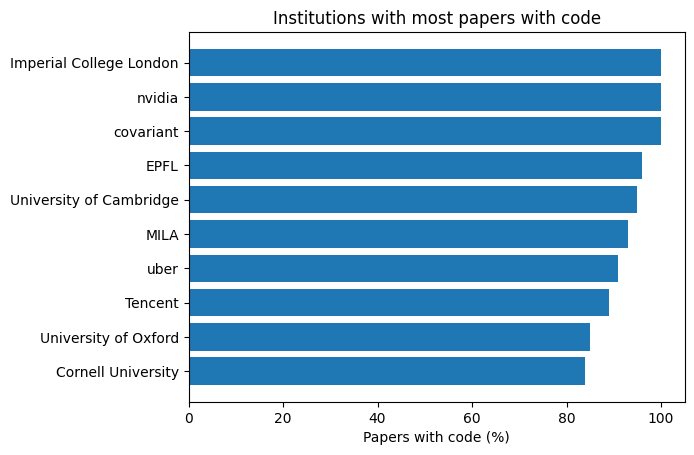

In [28]:
plt.rcdefaults()
fig, ax = plt.subplots()
top = 10
paper_counts = df["code (%)"].tolist()[:top]
institution_names = list(df[:top].index.values)
ax.barh(institution_names, paper_counts)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Papers with code (%)')
ax.set_title('Institutions with most papers with code')
plt.savefig(out_folder + 'most_papers_with_code.png', bbox_inches='tight')
plt.show()

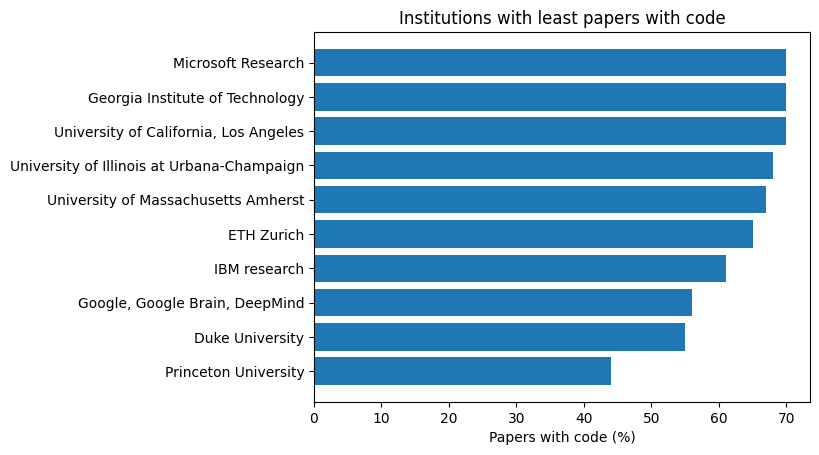

In [29]:
plt.rcdefaults()
fig, ax = plt.subplots()
top = 10
paper_counts = df["code (%)"].tolist()[-top:]
institution_names = list(df[-top:].index.values)
ax.barh(institution_names, paper_counts)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Papers with code (%)')
ax.set_title('Institutions with least papers with code')
plt.savefig(out_folder + 'least_papers_with_code.png', bbox_inches='tight')
plt.show()

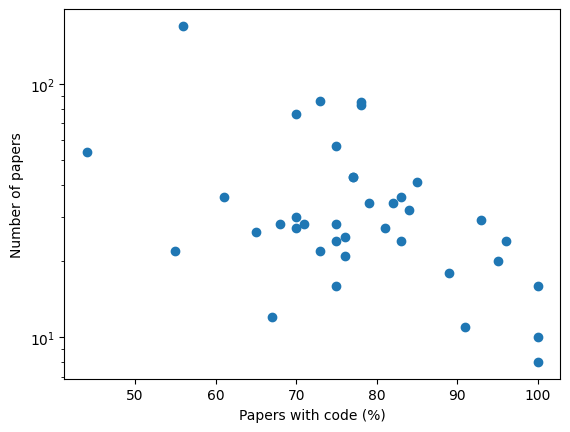

In [30]:
plt.rcdefaults()
fig, ax = plt.subplots()
code_release_fractions = df["code (%)"].tolist()
paper_counts = df['count'].tolist()
ax.scatter(code_release_fractions, paper_counts)
ax.set_xlabel('Papers with code (%)')
ax.set_ylabel('Number of papers')
ax.semilogy()
plt.savefig(out_folder + 'code_release_vs_paper_count.png', bbox_inches='tight')
plt.show()